In [1]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
status = '0'

In [4]:
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
import src.scanner as scanner
import os
import csv
import src.util as util
from datetime import datetime
from operator import itemgetter

def normalize_account(account, bin_sizes):
    out = np.zeros((np.sum(bin_sizes)), dtype=np.float32)
    out[0] = util.normalize(account[0], open_stat)
    out[1 + account[1]] = 1
    out[1 + bin_sizes[1]] = util.normalize(account[2], recent_stat)
    out[2 + bin_sizes[1]] = util.normalize(account[3], dormant_stat)
    out[3 + bin_sizes[1] + account[4]] = 1

    return out


def normalize_transactions(trans):
    #print (trans)
    for i in range(len(trans)):
        trans[i][0] = util.normalize(trans[i][0], amount_stat)
        trans[i][1] = util.normalize(trans[i][1], date_stat)

    return trans


def batch_to_one_hot(array_like, bin_sizes):
    #print ("array_like: ", array_like, "-bin_sizes ", bin_sizes, "-\n")
    out = np.zeros((len(array_like), np.sum(bin_sizes)), dtype=np.float32)
    for i in range(len(array_like)):
        last = 0
        for j in range(len(bin_sizes)):
            next_ = (last + bin_sizes[j])
            out[i, last:next_] = util.to_one_hot(array_like[i][j], bin_sizes[j])
            last = next_
    return out


def prep_data(tuples):
    #profiles = []
    trans = []
    labels = []

    for tuple in tuples:
        #profiles.append(normalize_account(tuple[0], [1, len(customer_types), 1, 1, len(units)]))
        trans.append(batch_to_one_hot(normalize_transactions(tuple[0]), [1, 1, len(operation_types)]))
        labels.append(1.0 if tuple[1] else 0)

    return (np.stack(trans), np.stack(labels))

def sort_transaction(transactions):
    return sorted(transactions, key=itemgetter(1))


def sequence_summarize(sorted_transactions):
    out = []
    temp = [0, 0, 0]
    for t in sorted_transactions:
        if t[1] == temp[1] and t[2] == temp[2]:
            temp[0] = temp[0] + t[0]
        else:
            out.append(temp)
            temp = [t[0], t[1], t[2]]
    out.append(temp)
    return out[1:]

stime = datetime.utcfromtimestamp(0)
dir_path = os.getcwd()

customer_types = []
units = []
operation_types = []


open_stat = util.get_start_stat()
recent_stat = util.get_start_stat()
dormant_stat = util.get_start_stat()
# freq_stat = util.get_start_stat()
# interest_stat = util.get_start_stat()

amount_stat = util.get_start_stat()
date_stat = util.get_start_stat()

# ====================== Transaction =====================

In [5]:
if status == 'server':
    sql = '''

    SELECT  *
    FROM InquiryLogStatement
    '''
    df_main2 = pd.read_sql(sql, con)

if status == 0:
    df_main2 = pd.read_csv('data/InquiryLogStatement.csv', sep='|')

df_main2['TransactionDate'] = pd.to_datetime(df_main2['TransactionDate'], format='%d/%m/%Y %H:%M:%S')


In [6]:
temp = pd.DataFrame({
    'InquiryLogID': df_main2['InquiryLogID'],
    'TransactionDate': df_main2['TransactionDate'],
    'Withdrawal': df_main2['Withdrawal'],
    'Deposit': df_main2['Deposit'],
})


In [7]:
temp['txn_type'] = temp['InquiryLogID']
temp.fillna(0, inplace=True)
temp['txn_type'] = temp['Withdrawal'].apply(lambda x: "CR" if x == 0 else "DR")

In [8]:
temp['Amount'] = temp['Deposit']
temp['Amount'] = None
temp['Amount'] = temp.apply(lambda x: x['Deposit'] if x['Withdrawal'] == 0 else x['Withdrawal'], axis=1)
temp['Amount'] = abs(temp['Amount'].apply(lambda x: str(x).replace(',', '')).astype(float))

In [9]:
col = ['account_no', 'from_to_account_no', 'txn_amount', 'txn_dt', 'txn_hour', 'txn_type']
df_tran = temp = pd.DataFrame({
    'account_no': temp['InquiryLogID'],
    'txn_amount': temp['Amount'],
    'txn_dt': temp['TransactionDate'],
    'txn_type': temp['txn_type'],
})

In [10]:
df_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955647 entries, 0 to 955646
Data columns (total 4 columns):
account_no    955647 non-null object
txn_amount    955647 non-null float64
txn_dt        955647 non-null datetime64[ns]
txn_type      955647 non-null object
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 29.2+ MB


In [11]:
df_tran.head()

,account_no,txn_amount,txn_dt,txn_type
0,93,500.0,2016-10-29 16:19:04,CR
1,93,500.0,2016-10-29 16:26:47,DR
2,93,500.0,2016-11-01 18:04:52,CR
3,94,700.0,2016-10-30 18:55:55,CR
4,94,700.0,2016-10-30 19:16:47,DR


In [12]:
a = df_tran['txn_dt']
a = a.apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
type(a[0])

str

In [13]:
from datetime import datetime
stime = datetime.utcfromtimestamp(0)
df_tran['txn_dt'] = a.apply(lambda y: (datetime.strptime(y, '%Y-%m-%d %H:%M:%S') - stime).total_seconds())

In [14]:
from sklearn.preprocessing import LabelEncoder
from numpy import array
def lblEn (x):
    data = x
    values = array(data)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    print(label_encoder.classes_)
    #print(label_encoder.inverse_transform(label_encoder.classes_))
    print ("values: ", values)
    print ("encode: ", integer_encoded)
    return integer_encoded

In [15]:
df_tran['txn_type'] = lblEn(df_tran['txn_type'])

['CR' 'DR']
values:  ['CR' 'DR' 'CR' ..., 'DR' 'DR' 'DR']
encode:  [0 1 0 ..., 1 1 1]


In [16]:
from sklearn.preprocessing import StandardScaler
def stdScal (x):
    x = StandardScaler().fit_transform(x.reshape(-1, 1))
    return x

In [17]:
df_tran['txn_amount'] = stdScal(df_tran['txn_amount'])
df_tran['txn_dt'] = stdScal(df_tran['txn_dt'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


In [18]:
df_tran

,account_no,txn_amount,txn_dt,txn_type
0,93,-0.007508,-0.706983,0
1,93,-0.007508,-0.706925,1
2,93,-0.007508,-0.673417,0
3,94,-0.007460,-0.694872,0
4,94,-0.007460,-0.694714,1
5,94,-0.007508,-0.685856,0
6,95,-0.007508,-0.688010,0
7,95,-0.007508,-0.687871,1
8,95,-0.007579,-0.677507,0
9,95,-0.007603,-0.677467,1


In [20]:
account_transactions = {}
print("reading transaction file...")

for index, row in df_tran.iterrows():
    transaction = []
    # transaction.append(row[0])  # account id
    transaction.append(util.collect_statistics(amount_stat, row[1]))   #amount
    transaction.append(util.collect_statistics(date_stat,(row[2])))    #dateTime
    transaction.append(util.check_and_update_list(operation_types, row[3]))  # type

    if row[0] in account_transactions:
        account_transactions[row[0]].append(transaction)
    else:
        account_transactions[row[0]] = [transaction]

reading transaction file...


## TRAIN Model

In [21]:
status = 0

In [22]:
if status == 'server':
    sql = '''
select *
, (select top 1 accountflag from watchlist as a where a.InquiryLogID = m.InquiryLogID) as [AccountFlag]
 from (
	select w.[InquiryLogID], count(InquiryLogStatementID) as c from 
	( 
		SELECT [InquiryLogID], [AccountFlag] FROM
		(
			select 
				Rank() over (Partition by accountno Order by convert(datetime, createdate, 103) desc) ranks
					,accountno as ac, *  
			FROM [LAB].[dbo].[WatchList]
		) as A
		where ranks = 1 and DataSourceID in (1, 2) and [InquiryLogID] not in (0)
	) as W
	left join [InquiryLogStatement] as I
	on W.[InquiryLogID] = I.[InquiryLogID]
	group by W.InquiryLogID
) as m
where c > 5
    '''
    df_main_list = pd.read_sql(sql, con)

if status ==0:
    df_main_list = pd.read_csv('data/Sedit.csv', sep=',')

In [23]:
df_main_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5112 entries, 0 to 5111
Data columns (total 3 columns):
InquiryLogID    5112 non-null int64
c               5112 non-null int64
AccountFlag     5112 non-null object
dtypes: int64(2), object(1)
memory usage: 119.9+ KB


In [24]:
df_main_list_S = df_main_list.sample(n=1000, replace=True)

In [25]:
df_main_list_S

,InquiryLogID,c,AccountFlag
1807,18819,100,S
2900,23153,82,S
2412,21058,100,S
3809,37071,100,S
1730,18607,36,S
4559,39348,87,S
1532,17822,9,S
3979,37556,100,S
1263,16495,55,S
4497,39114,100,S


In [26]:
df_main_list2 = pd.read_csv('data/Redit.csv', sep=',')
#df_main_list3 = pd.read_csv('data/test/R_test.csv', sep=',')

In [27]:
df_main_list2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 3 columns):
InquiryLogID    403 non-null int64
c               403 non-null int64
AccountFlag     403 non-null object
dtypes: int64(2), object(1)
memory usage: 9.5+ KB


In [28]:
df_main = pd.concat([df_main_list_S, df_main_list2], ignore_index=True, verify_integrity=True)
#df_main = pd.concat([df_main, df_main_list3], ignore_index=True, verify_integrity=True)

In [29]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403 entries, 0 to 1402
Data columns (total 3 columns):
InquiryLogID    1403 non-null int64
c               1403 non-null int64
AccountFlag     1403 non-null object
dtypes: int64(2), object(1)
memory usage: 33.0+ KB


In [31]:
df_main['AccountFlag'] = df_main['AccountFlag'].replace({'S': 0, 'R': 1})

In [32]:
df_main

,InquiryLogID,c,AccountFlag
0,18819,100,0
1,23153,82,0
2,21058,100,0
3,37071,100,0
4,18607,36,0
5,39348,87,0
6,17822,9,0
7,37556,100,0
8,16495,55,0
9,39114,100,0


In [33]:
if status == 0:
    df_main.drop('c', axis=1, inplace=True)

In [34]:
label = []
arr_main = []
accNo = []
print("reading training file...")
for row in df_main.values:
    acc_id = str(row[0])
    flag = row[1]
    print ("acc:", acc_id)
    print ("flag:", flag)

    if acc_id in account_transactions.keys():
        transactions = sequence_summarize(sort_transaction(account_transactions[acc_id]))
        arr_main.append(transactions)
        label.append(flag)
        accNo.append(acc_id)
        print("**")

reading training file...
acc: 18819
flag: 0
**
acc: 23153
flag: 0
**
acc: 21058
flag: 0
**
acc: 37071
flag: 0
**
acc: 18607
flag: 0
**
acc: 39348
flag: 0
**
acc: 17822
flag: 0
**
acc: 37556
flag: 0
**
acc: 16495
flag: 0
**
acc: 39114
flag: 0
**
acc: 10675
flag: 0
**
acc: 38304
flag: 0
**
acc: 40944
flag: 0
**
acc: 12995
flag: 0
**
acc: 23579
flag: 0
**
acc: 36980
flag: 0
**
acc: 14209
flag: 0
**
acc: 10906
flag: 0
**
acc: 37558
flag: 0
**
acc: 38517
flag: 0
**
acc: 37044
flag: 0
**
acc: 18606
flag: 0
**
acc: 38400
flag: 0
**
acc: 13192
flag: 0
**
acc: 39969
flag: 0
**
acc: 479
flag: 0
**
acc: 40935
flag: 0
**
acc: 34637
flag: 0
**
acc: 36061
flag: 0
**
acc: 16003
flag: 0
**
acc: 22527
flag: 0
**
acc: 13716
flag: 0
**
acc: 23194
flag: 0
**
acc: 13398
flag: 0
**
acc: 34231
flag: 0
**
acc: 38720
flag: 0
**
acc: 39665
flag: 0
**
acc: 23593
flag: 0
**
acc: 35997
flag: 0
**
acc: 38418
flag: 0
**
acc: 20991
flag: 0
**
acc: 40833
flag: 0
**
acc: 39351
flag: 0
**
acc: 13150
flag: 0
**
acc: 2113

In [35]:
#len(account_transactions[47755])

In [36]:
from keras.preprocessing.sequence import pad_sequences
def seq_pad(x):
    padded = pad_sequences(x, dtype=float, padding='pre', maxlen=15)
    return padded

Using TensorFlow backend.


In [37]:
dataset = seq_pad(arr_main)

In [38]:
import numpy as np
myarray = np.asarray(label)
myarray = myarray.astype(int)

##  test data 

# K-fold 
https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

In [39]:
X_train = dataset
y_train = myarray
X_test = dataset
y_test = myarray

# ================ LSTM ====

In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import classification_report

In [42]:
X_train = dataset
y_train = myarray


In [43]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.2))
model.add(LSTM(20, dropout=0.3))
model.add(Dense(1,activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=2)
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

predict = model.predict_classes(X_test)
print(classification_report(y_test, predict))

Epoch 1/200
6s - loss: 0.6288 - acc: 0.6978
Epoch 2/200
0s - loss: 0.5999 - acc: 0.7128
Epoch 3/200
0s - loss: 0.5946 - acc: 0.7128
Epoch 4/200
0s - loss: 0.5858 - acc: 0.7135
Epoch 5/200
0s - loss: 0.5619 - acc: 0.7213
Epoch 6/200
0s - loss: 0.5693 - acc: 0.7185
Epoch 7/200
0s - loss: 0.5424 - acc: 0.7227
Epoch 8/200
0s - loss: 0.5308 - acc: 0.7363
Epoch 9/200
0s - loss: 0.5256 - acc: 0.7356
Epoch 10/200
0s - loss: 0.5331 - acc: 0.7227
Epoch 11/200
0s - loss: 0.5314 - acc: 0.7270
Epoch 12/200
0s - loss: 0.5350 - acc: 0.7334
Epoch 13/200
0s - loss: 0.5354 - acc: 0.7334
Epoch 14/200
0s - loss: 0.5221 - acc: 0.7391
Epoch 15/200
0s - loss: 0.5129 - acc: 0.7520
Epoch 16/200
0s - loss: 0.5209 - acc: 0.7406
Epoch 17/200
0s - loss: 0.5072 - acc: 0.7477
Epoch 18/200
0s - loss: 0.5208 - acc: 0.7370
Epoch 19/200
0s - loss: 0.5138 - acc: 0.7434
Epoch 20/200
0s - loss: 0.5102 - acc: 0.7384
Epoch 21/200
0s - loss: 0.5014 - acc: 0.7484
Epoch 22/200
0s - loss: 0.5110 - acc: 0.7434
Epoch 23/200
0s - l

In [ ]:
X_test = dataset
y_test = myarray

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
predict = model.predict_classes(X_test)

# PLOT

dict_keys(['loss', 'acc'])


KeyError: 'val_acc'

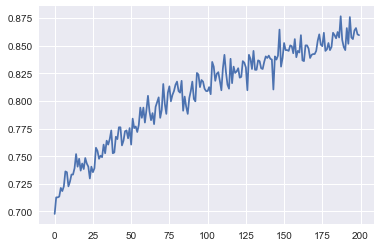

In [44]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# ======= create file json

In [45]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os

# serialize model to JSON
model_json = model.to_json()
with open("model_Implement!!.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_Implement!!.h5")
print("Saved model to disk")

Saved model to disk


# Load & Predict

In [46]:
# later...

# load json and create model
json_file = open('model_Implement!!.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model_Implement!!.h5")
print("Loaded model from disk")


# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
predict = loaded_model.predict_classes(X_test)

Loaded model from disk
1248/1403 [=========================>....] - ETA: 0s 

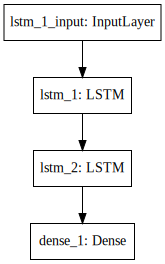

In [47]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))